<a href="https://colab.research.google.com/github/rijalmyd/api-pkm/blob/main/RawitMerah2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib

In [ ]:
url = "https://raw.githubusercontent.com/rijalmyd/machine_learning/main/CabaiRawitMerahFix.csv"
df = pd.read_csv(url)
df

,tanggal,harga
0,02-01-2020,24400
1,03-01-2020,24400
2,06-01-2020,24400
3,07-01-2020,24400
4,08-01-2020,24400
...,...,...
711,29-11-2022,22500
712,30-11-2022,22500
713,01-12-2022,22500
714,02-12-2022,22500


In [ ]:
df.isnull().sum()

tanggal    0
harga      0
dtype: int64

In [ ]:
def normalize_data(df):
    scaler = MinMaxScaler()
    df['harga'] = scaler.fit_transform(df['harga'].values.reshape(-1,1))
    return df

df_new = normalize_data(df)
df_new.shape

(716, 2)

Text(0.5, 1.0, 'Plot Cabai Rawit Merah 2020-2022')

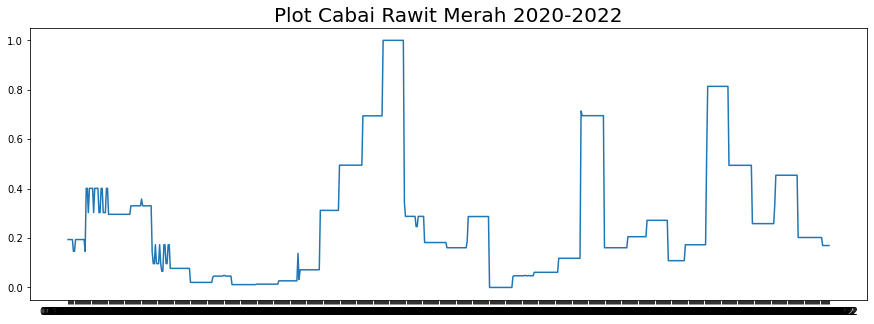

In [ ]:
year = df_new['tanggal'].values
total  = df_new['harga'].values

plt.figure(figsize=(15,5))
plt.plot(year, total)
plt.title('Plot Cabai Rawit Merah 2020-2022', fontsize=20)

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(total, year, test_size=0.2, shuffle=False )

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=60, batch_size=100, shuffle_buffer=1000)

In [ ]:
model = tf.keras.models.Sequential([
  LSTM(60, return_sequences=True),
  LSTM(60),
  Dense(30, activation="relu"),
  Dropout(0.5),
  Dense(10, activation="relu"),
  Dropout(0.2),
  Dense(1)
])

In [ ]:
threshold_mae = (df_new['harga'].max() - df_new['harga'].min()) * 10/100
print(threshold_mae)

0.1


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae):
      print("\nMAE model sudah < 10% skala data")
      self.model.stop_training = True
callback = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)
history = model.fit(
    train_set,
    epochs=100,
    validation_data=val_set,
    callbacks=[callback]
)

Epoch 1/100
6/6 [==============================] - 10s 328ms/step - loss: 0.0564 - mae: 0.2260 - val_loss: 0.0573 - val_mae: 0.3155
Epoch 2/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0568 - mae: 0.2257 - val_loss: 0.0565 - val_mae: 0.3130
Epoch 3/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0554 - mae: 0.2213 - val_loss: 0.0555 - val_mae: 0.3098
Epoch 4/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0545 - mae: 0.2182 - val_loss: 0.0544 - val_mae: 0.3062
Epoch 5/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0537 - mae: 0.2149 - val_loss: 0.0532 - val_mae: 0.3023
Epoch 6/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0537 - mae: 0.2127 - val_loss: 0.0520 - val_mae: 0.2984
Epoch 7/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0524 - mae: 0.2094 - val_loss: 0.0507 - val_mae: 0.2944
Epoch 8/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0516 - mae: 0.

In [ ]:
joblib.dump(model, "model.pkl")
model.save("model.h5")